# 1. Importing Libraries and Data

In [5]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#  world maps
import folium
from folium.plugins import MarkerCluster


In [12]:
path = 'C:/Users/santi/HiDrive/users/santina/02_Data Analytics/Bootcamp/06_Advanced-Analytics/02_Data/Clean Data'

In [16]:
df = pd.read_csv(os.path.join(path, 'suicide-rates-cleaned.csv'))

In [17]:
gps = pd.read_csv(os.path.join(path, 'world-capital-gps.csv'))

# 2. Joining the Datasets

In [18]:
# verify country names are consistent in df and gps dataframes
count = 0
for i in sorted(df.country.unique()):
    if len(gps.CountryName[gps.CountryName == i].values) == 0:
        print('MISSING:  df: {:<35}gps:{}'.format(i,gps.CountryName[gps.CountryName == i].values))
        count = count + 1
print('check complete:  {} missing'.format(count)) 

MISSING:  df: Cabo Verde                         gps:[]
MISSING:  df: Republic of Korea                  gps:[]
MISSING:  df: Russian Federation                 gps:[]
MISSING:  df: Saint Vincent and Grenadines       gps:[]
check complete:  4 missing


In [19]:
#  update names in df to match the gps file
df.replace({'Cabo Verde':'Cape Verde','Republic of Korea':'South Korea','Russian Federation':'Russia','Saint Vincent and Grenadines':'Saint Vincent and the Grenadines'},inplace=True)

In [20]:
# join the datasets using the country names as key
df = df.join(gps.set_index('CountryName'), on='country')
print(df.shape)

(27820, 16)


# 3. Cleaning the Data

In [25]:
#  drop un-needed columns
df = df.drop([' gdp_for_year ($) ', 'country-year', 'CountryCode', 'CapitalName'], axis=1)
# sort dataframe by country and year
df = df.sort_values(['country','year'])

print(df.shape)

(27820, 12)


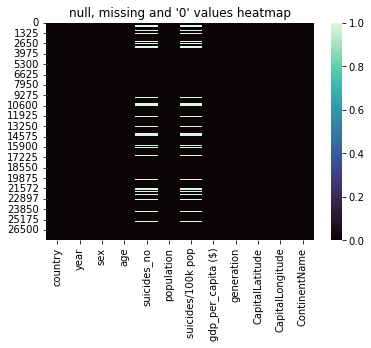


DUPLICATE VALUE COUNT:   0


In [28]:
# check null, missing and '0' values


plt.title('null, missing and \'0\' values heatmap')
sns.heatmap((df.isnull()) | (df == 0), cmap = 'mako')
plt.show()

print('\nDUPLICATE VALUE COUNT:  ', df.duplicated().sum())

suicides_no and suicides/100 k pop have missing values. no duplicates found

In [29]:
#  percentage missing for 'suicides/100k pop' - before
for i in ['suicides_no', 'suicides/100k pop']:
    missing_before = len(df[df[i] == 0])*100/len(df)
    print(' before: {:>20} == 0:  {:>8.4f}%'.format(i,missing_before))
    
#  BEFORE - missing 'suicides_no' and 'suicides/100k pop'
sui_before = df[['suicides_no', 'suicides/100k pop']]

    
#  drop 'df['suicides/100k pop'] == 0' rows
len(df[df['suicides/100k pop'] == 0].index)
df.drop(df[df['suicides/100k pop'] == 0].index, inplace = True)

#  percentage missing for 'suicides/100k pop' - after
for i in ['suicides_no', 'suicides/100k pop']:
    missing_after = len(df[df[i] == 0])*100/len(df)
    print(' after:  {:>20} == 0:  {:>8.2f}%'.format(i,missing_after))

#  AFTER - missing 'suicides_no' and 'suicides/100k pop'
sui_after = df[['suicides_no', 'suicides/100k pop']]

 before:          suicides_no == 0:   15.3882%
 before:    suicides/100k pop == 0:   15.3882%
 after:           suicides_no == 0:      0.00%
 after:     suicides/100k pop == 0:      0.00%


In [31]:
# there are significantlly less data for 2016, so I will drop the data for that year
#  drop year = 2016
print('before 2016 data drop:  ',df.shape)
df.drop(df[df['year'] == 2016].index, inplace = True)
print('after  2016 data drop:  ',df.shape)

before 2016 data drop:   (23539, 12)
after  2016 data drop:   (23399, 12)


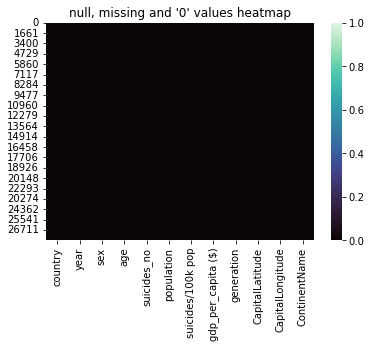


DUPLICATE COUNT:   0


In [32]:
# final check


plt.title('null, missing and \'0\' values heatmap')
sns.heatmap((df.isnull()) | (df == 0), cmap = 'mako')
plt.show()

print('\nDUPLICATE COUNT:  ', df.duplicated().sum())



no more duplicates and missing values found

# 4. Data Overview

In [34]:
#  Top 10 most populous countries in the world
top10 = ['China','India','United States','Indonesia','Brazil','Pakistan','Nigeria','Bangladesh','Russia','Mexico']
in_set = df.country[df.country.str.contains('|'.join(top10))].unique().tolist()

print('Out of the top 10 most populous countries:\n{}\n\nOnly the following {} are present:\n{}'.format(top10,len(in_set),in_set))

#  dataset
print('\n\nDataset has', len(df['country'].unique()),'countries on' ,len(df['ContinentName'].unique()),'continents spanning' ,len(df['year'].unique()),'years.')

Out of the top 10 most populous countries:
['China', 'India', 'United States', 'Indonesia', 'Brazil', 'Pakistan', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico']

Only the following 4 are present:
['Brazil', 'Mexico', 'Russia', 'United States']


Dataset has 98 countries on 7 continents spanning 31 years.


In [35]:
#  SET UP CONTINENT DATAFRAME
#  population, population percent and country count per continent
df_cont = df.groupby('ContinentName')['population'].sum().reset_index()
df_cont['Population Percentage'] = df_cont['population']*100/df_cont['population'].sum()

#  countries count per continent
cntCont = df['country'].groupby(df['ContinentName']).nunique()

#  add countryCount column to df_cont
df_cont['countryCount'] = cntCont[df_cont['ContinentName']].values 

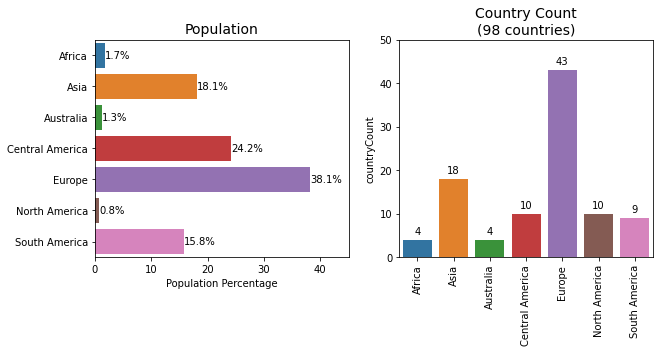

In [36]:
# plot population and country count per continent
plt.figure(figsize=(10,4))
plt.subplot(121)
ax = sns.barplot(data = df_cont, x = 'Population Percentage', y='ContinentName')
plt.title('Population', fontsize=14)
plt.xlim([0,45])
plt.ylabel("")
for p in ax.patches:
    ax.annotate("{:,.1f}%".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y()+.4), ha='left', va='center')

plt.subplot(122)
ax = sns.barplot(data = df_cont, x = 'ContinentName', y='countryCount')
plt.title('Country Count\n({} countries)'.format(df_cont.countryCount.sum()), fontsize=14)
plt.xlabel('')
plt.xticks(rotation = 90)
plt.ylim([0,50])
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2, p.get_height()+2), ha='center', va='center')
    
plt.show()

DATA OVERVIEW:
- 6 of the most populous countries are missing
- China and India account for almost 30% of the global population and are missing
- most of African countries are missing
- Europe has 43 out of 98 countries in the data and accounts for 38% of the population
- It is safe to assume that analysis will be skewed towards European countries

# 5. Visualization

In [38]:
#  create an ordered list for plotting:
cont_list = df.ContinentName.sort_values().unique()
cont_glob = np.insert(cont_list, 0, 'Global')  # add Global as 1st
age_list = ['5-14 years', '15-24 years', '25-34 years', '35-54 years',  '55-74 years', '75+ years']

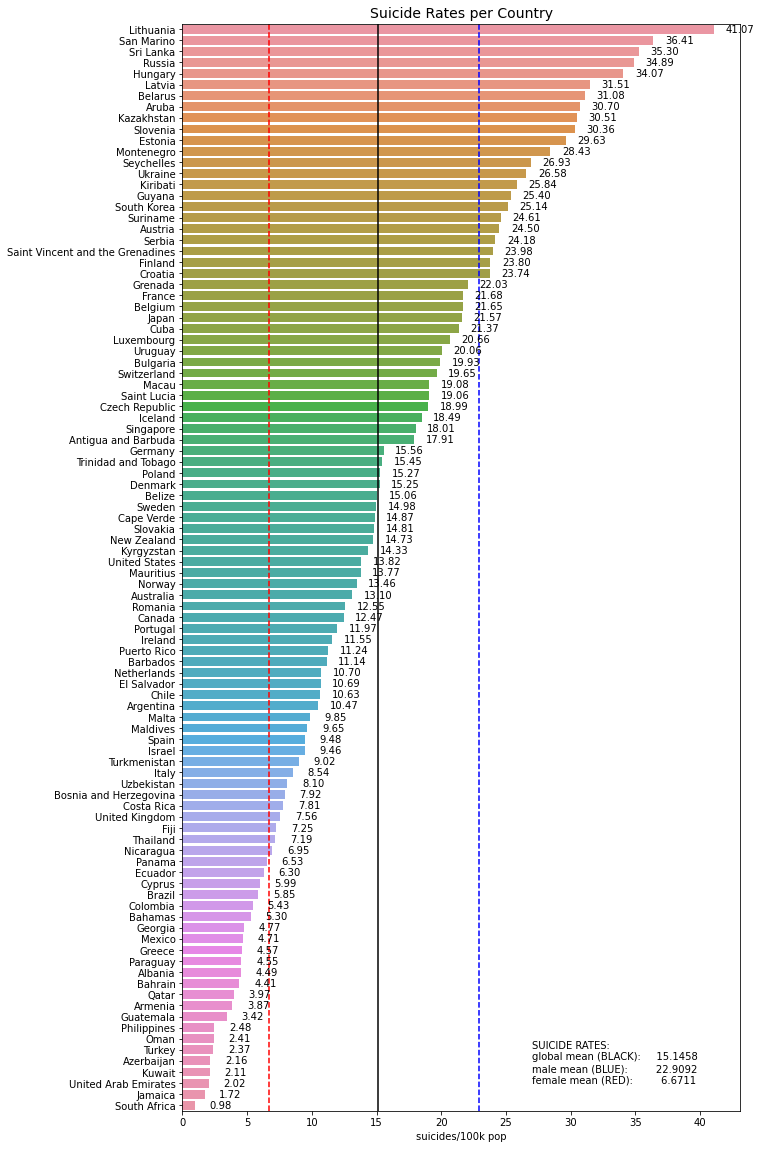

In [39]:
# Suicide Rates per Country

#  suicide rate average: overall, male, female
suicide_mean = df['suicides/100k pop'].mean()
sr_m = df['suicides/100k pop'][df['sex'] == 'male'].mean()
sr_f = df['suicides/100k pop'][df['sex'] == 'female'].mean()

#  dataframe with suicide averages for each country
df_suicideRate = df['suicides/100k pop'].groupby(df['country']).mean().sort_values(ascending=False).reset_index()

#  plot suicide rates per country
plt.figure(figsize=(10,20))
ax = sns.barplot(data = df_suicideRate, x = 'suicides/100k pop', y='country')
plt.title('Suicide Rates per Country', fontsize=14)

#plt.xlabel('suicides/100k pop\n\noverall mean: {:>18.2f}\nmale mean (BLUE): {:>8.2f}\nfemale mean (RED): {:>18.2f}'.format(suicide_mean, sr_m, sr_f))
plt.text(27,95,'SUICIDE RATES:\nglobal mean (BLACK):  {:>10.4f}\nmale mean (BLUE): {:>15.4f}\nfemale mean (RED): {:>14.4f}'.format(suicide_mean, sr_m, sr_f))
plt.axvline(x= suicide_mean, color = 'black')#, ls = '--')
plt.axvline(x= sr_m, color = 'blue', ls = '--')
plt.axvline(x= sr_f, color = 'red', ls = '--')
plt.ylabel("")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width() +2, p.get_y()+.4), ha='center', va='center')
plt.show()

Conclusions
- Global suicides rates is 15.17 per 100k of the population
- males are 3.5 more likely to commit suicide than females (22.96 vs 6.68)
- European countries, such as Latvia, Hungary and Belarus, have significantly higher suicide rates


# Choropleth World Map

In [42]:
# Create Folium World Map

#  create dataframe for mapping
mapdf = pd.DataFrame(columns =  ['country','suicides_no','lat','lon'])

In [43]:
mapdf.lat = mapdf.lat.astype(float).fillna(0.0)
mapdf.lon = mapdf.lat.astype(float).fillna(0.0)

In [44]:
mapdf['country']     = df['suicides_no'].groupby(df['country']).sum().index
mapdf['suicides_no'] = df['suicides_no'].groupby(df['country']).sum().values

In [46]:
# import MarkerCluster
import MarkerCluster

In [48]:
world_map.add_child(marker_cluster)

In [49]:
#  create dataframe with Country and mean of Suicide rates per 100k Population
df_choro = df[['suicides/100k pop','country']].groupby(['country']).mean().sort_values(by='suicides/100k pop').reset_index()

In [50]:
#  Update US name to match JSON file
df_choro.replace({'United States':'United States of America'},inplace=True)

In [53]:
#import json
import json

In [57]:
# Import ".json" file for the world 

world_geo = r'C:/Users/santi/HiDrive/users/santina/02_Data Analytics/Bootcamp/06_Advanced-Analytics/02_Data/Clean Data/world-countries.json'

In [58]:
world_choropelth = folium.Map(location=[0, 0], tiles='Cartodb Positron',zoom_start=1)

world_choropelth.choropleth(
    geo_data=world_geo,
    data=df_choro,
    columns=['country','suicides/100k pop'],
    key_on='feature.properties.name',
    fill_color='PuBu',  # YlGn
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Suicide Rates per 100k Population')
 
# display map
world_choropelth

The Choropleth is interessting because it shows the suicide rates by country well visualized. It also shows clearly that the data is biased as there are way more data for european countries than the rest of the world. For example, most of the african countries are missing. 